Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.81MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/100: Train Loss = 3.5533, Val Loss = 3.8188
Epoch 2/100: Train Loss = 3.8293, Val Loss = 3.1946
Epoch 3/100: Train Loss = 3.2884, Val Loss = 2.5750
Epoch 4/100: Train Loss = 2.6644, Val Loss = 2.0706
Epoch 5/100: Train Loss = 2.1919, Val Loss = 2.1676
Epoch 6/100: Train Loss = 2.2492, Val Loss = 1.8531
Epoch 7/100: Train Loss = 1.9567, Val Loss = 1.6876
Epoch 8/100: Train Loss = 1.8052, Val Loss = 1.9642
Epoch 9/100: Train Loss = 2.0530, Val Loss = 1.9290
Epoch 10/100: Train Loss = 2.0116, Val Loss = 1.7063
Epoch 11/100: Train Loss = 1.7894, Val Loss = 1.5533
Epoch 12/100: Train Loss = 1.6394, Val Loss = 1.5595
Epoch 13/100: Train Loss = 1.6473, Val Loss = 1.4397
Epoch 14/100: Train Loss = 1.5223, Val Loss = 1.3803
Epoch 15/100: Train Loss = 1.4696, Val Loss = 1.3183
Epoch 16/100: Train Loss = 1.4037, Val Loss = 1.2891
Epoch 17/100: Train Loss = 1.3740, Val Loss = 1.2639
Epoch 18/100: Train Loss = 1.3497

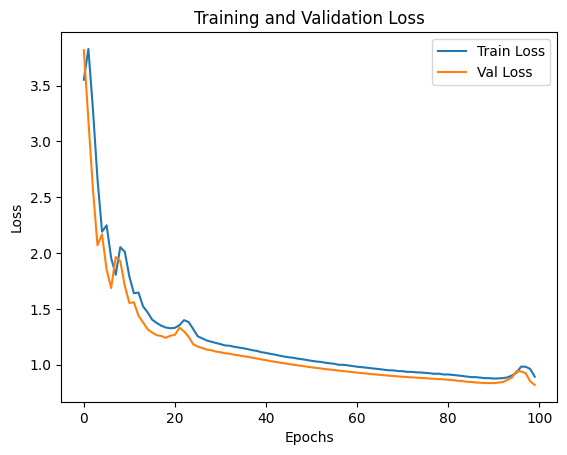

Test Accuracy: 93.48%


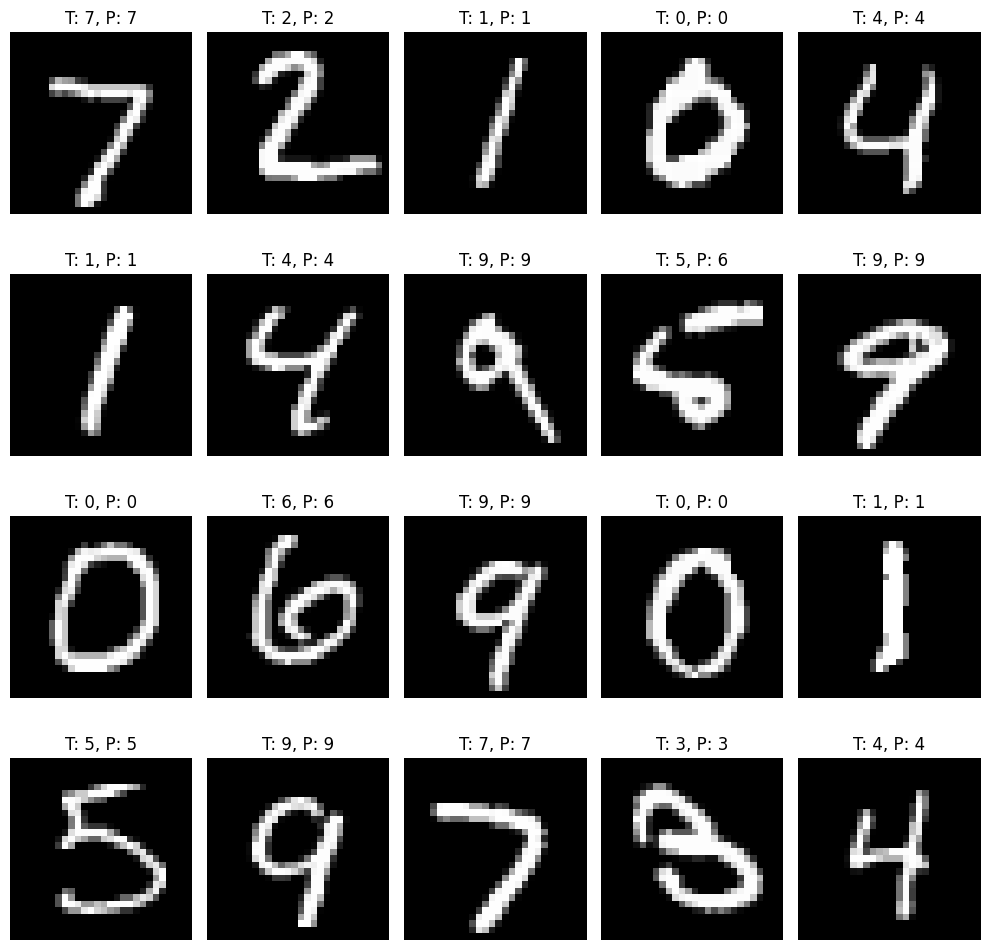

In [ ]:
import torch
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

# Activation functions and their derivatives
ACTIVATIONS = {
    "relu": (lambda Z: np.maximum(0, Z), lambda Z: (Z > 0).astype(float)),
    "sigmoid": (lambda Z: 1 / (1 + np.exp(-Z)), lambda Z: Z * (1 - Z)),
    "tanh": (lambda Z: np.tanh(Z), lambda Z: 1 - np.tanh(Z)**2),
}

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def compute_loss(Y, Y_hat, params, l2_lambda):
    """Cross-entropy loss with L2 regularization."""
    cross_entropy_loss = -np.mean(np.sum(Y * np.log(Y_hat + 1e-8), axis=0))
    l2_loss = l2_lambda * sum([np.sum(np.square(params[f"W{i}"])) for i in range(1, len(params) // 2 + 1)])
    return cross_entropy_loss + l2_loss

class NeuralNetwork:
    def __init__(self, layers, activations, lr=0.001, l2_lambda=0.001, dropout_rate=0.2, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.layers = layers
        self.activations = activations
        self.lr = lr
        self.l2_lambda = l2_lambda
        self.dropout_rate = dropout_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.params = self._initialize_weights()

        # Initialize components for dual optimization
        self.momentums = {f"W{i}": np.zeros_like(self.params[f"W{i}"]) for i in range(1, len(layers))}
        self.velocities = {f"W{i}": np.zeros_like(self.params[f"W{i}"]) for i in range(1, len(layers))}
        self.squared_gradients = {f"W{i}": np.zeros_like(self.params[f"W{i}"]) for i in range(1, len(layers))}

    def _initialize_weights(self):
        np.random.seed(42)
        return {
            f"W{i}": np.random.randn(self.layers[i], self.layers[i-1]) * np.sqrt(2 / self.layers[i-1])
            for i in range(1, len(self.layers))
        } | {
            f"b{i}": np.zeros((self.layers[i], 1)) for i in range(1, len(self.layers))
        }

    def _apply_dropout(self, A, training):
        if training:
            dropout_mask = np.random.rand(*A.shape) > self.dropout_rate
            return A * dropout_mask / (1 - self.dropout_rate)
        return A

    def forward(self, X, training=True):
        cache = {"A0": X}
        for i in range(1, len(self.layers)):
            Z = self.params[f"W{i}"] @ cache[f"A{i-1}"] + self.params[f"b{i}"]
            activation, _ = ACTIVATIONS[self.activations[i-1]] if i < len(self.layers) - 1 else (softmax, None)
            A = activation(Z)
            if i < len(self.layers) - 1:  # Apply dropout only to hidden layers
                A = self._apply_dropout(A, training)
            cache[f"Z{i}"], cache[f"A{i}"] = Z, A
        return cache[f"A{len(self.layers)-1}"], cache

    def backward(self, X, Y, cache):
        grads = {}
        m = X.shape[1]
        A_final = cache[f"A{len(self.layers)-1}"]
        dZ = A_final - Y
        for i in reversed(range(1, len(self.layers))):
            grads[f"dW{i}"] = dZ @ cache[f"A{i-1}"].T / m + (self.l2_lambda * self.params[f"W{i}"])
            grads[f"db{i}"] = np.sum(dZ, axis=1, keepdims=True) / m
            if i > 1:
                _, derivative = ACTIVATIONS[self.activations[i-2]]
                dZ = (self.params[f"W{i}"].T @ dZ) * derivative(cache[f"Z{i-1}"])
        return grads

    def update_params(self, grads, t):
        for i in range(1, len(self.layers)):
            # Adam optimizer
            self.momentums[f"W{i}"] = self.beta1 * self.momentums[f"W{i}"] + (1 - self.beta1) * grads[f"dW{i}"]
            self.velocities[f"W{i}"] = self.beta2 * self.velocities[f"W{i}"] + (1 - self.beta2) * (grads[f"dW{i}"] ** 2)

            # Bias correction for Adam
            m_hat = self.momentums[f"W{i}"] / (1 - self.beta1 ** t)
            v_hat = self.velocities[f"W{i}"] / (1 - self.beta2 ** t)

            # RMSprop optimizer
            self.squared_gradients[f"W{i}"] = self.beta2 * self.squared_gradients[f"W{i}"] + (1 - self.beta2) * (grads[f"dW{i}"] ** 2)
            rms_update = grads[f"dW{i}"] / (np.sqrt(self.squared_gradients[f"W{i}"] + self.epsilon))

            # Dual optimization: average of Adam and RMSprop updates
            adam_update = m_hat / (np.sqrt(v_hat) + self.epsilon)
            combined_update = 0.5 * (adam_update + rms_update)

            # Apply updates to weights and biases
            self.params[f"W{i}"] -= self.lr * combined_update
            self.params[f"b{i}"] -= self.lr * grads[f"db{i}"]

    def train(self, X, Y, X_val, Y_val, epochs=50, early_stopping=10):
        best_loss, patience = float("inf"), early_stopping
        train_losses, val_losses = [], []
        for epoch in range(epochs):
            # Training
            Y_hat, cache = self.forward(X, training=True)
            train_loss = compute_loss(Y, Y_hat, self.params, self.l2_lambda)
            grads = self.backward(X, Y, cache)
            self.update_params(grads, epoch + 1)  # Pass epoch to Adam optimizer for bias correction

            # Validation
            val_loss = compute_loss(Y_val, self.forward(X_val, training=False)[0], self.params, self.l2_lambda)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

            # Early stopping
            if val_loss < best_loss:
                best_loss, patience = val_loss, early_stopping
            else:
                patience -= 1
                if patience == 0:
                    print("Early stopping triggered!")
                    break
        return train_losses, val_losses

    def predict(self, X):
        Y_hat, _ = self.forward(X, training=False)
        return np.argmax(Y_hat, axis=0)

def load_mnist_data():
    train_dataset = datasets.MNIST(root="./data", train=True, download=True)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True)

    # Convert to NumPy and normalize
    X_train = np.array([np.array(image) for image in train_dataset.data]) / 255.0
    y_train = np.array(train_dataset.targets)
    X_test = np.array([np.array(image) for image in test_dataset.data]) / 255.0
    y_test = np.array(test_dataset.targets)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Split data using NumPy instead of sklearn
    num_train = int(X_train.shape[0] * 0.8)  # 80% for training
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    X_train, X_val = X_train[indices[:num_train]], X_train[indices[num_train:]]
    y_train, y_val = y_train[indices[:num_train]], y_train[indices[num_train:]]

    # One-hot encoding using NumPy instead of sklearn
    def one_hot_encode(y, num_classes=10):
        encoded = np.zeros((y.size, num_classes))
        encoded[np.arange(y.size), y] = 1
        return encoded

    y_train = one_hot_encode(y_train).T
    y_val = one_hot_encode(y_val).T
    y_test = one_hot_encode(y_test).T

    return X_train.T, y_train, X_val.T, y_val, X_test.T, y_test

def plot_predictions(X, Y_true, Y_pred, num_images=16):
    """Display a grid of images with their true and predicted labels."""
    num_rows = int(np.sqrt(num_images))
    num_cols = num_images // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        image = X[:, i].reshape(28, 28)
        true_label = np.argmax(Y_true[:, i])
        pred_label = Y_pred[i]
        ax.imshow(image, cmap="gray")
        ax.set_title(f"T: {true_label}, P: {pred_label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load and preprocess data
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_mnist_data()

    # Define neural network
    nn = NeuralNetwork(
        layers=[784, 256, 128, 64, 10],
        activations=["tanh", "tanh", "tanh"],
        lr=0.001,
        l2_lambda=0.001,
        dropout_rate=0.2
    )

    # Train the model
    train_losses, val_losses = nn.train(X_train, Y_train, X_val, Y_val, epochs=100)

    # Plot loss curves
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    # Test the model
    predictions = nn.predict(X_test)
    test_accuracy = np.mean(predictions == np.argmax(Y_test, axis=0))
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Visualize predictions
    plot_predictions(X_test, Y_test, predictions, num_images=20)
